In [1]:
import numpy as np
from numba import njit, prange
import random

In [2]:
A, B = [], []
rows, cols = 250, 250
def gen_rnd_matrix(rows, cols):
    M = []
    for i in range(rows):
        row = []
        for j in range(cols):
            row.append(random.randint(0, 2 ** 16))
        M.append(row)
    return M
A = gen_rnd_matrix(rows, cols)
B = gen_rnd_matrix(rows, cols)
len(A), len(A[0])

(250, 250)

### python

In [3]:
def dot(a: list, b: list):
    accum = []
    for a_val, b_val in zip(a, b):
        accum.append(a_val * b_val)
    return sum(accum)

In [4]:
assert dot(A[0], B[0]) == np.dot(A[0], B[0])

In [5]:
def matmul(a: list[list], b: list[list]):
    m = len(a)
    p = len(b[0]) 
    c = []
    for i in range(m):
        row = []
        for j in range(p):
            row.append(dot(a[i], [r[j] for r in b]))
        c.append(row)
    return c

In [6]:
assert (matmul(A, B) == np.matmul(A, B)).all()

### jit

In [7]:
@njit()
def jdot(a: np.array, b: np.array):
    accum = 0
    for i in range(len(a)):
        accum += a[i] * b[i]
    return accum

In [8]:
@njit(parallel=True)
def jmatmul(a: np.array, b: np.array):
    c = np.zeros((a.shape[0], b.shape[1]))
    for i in prange(c.shape[0]):
        for j in prange(c.shape[1]):
            c[i, j] = jdot(a[i, :], b[:, j])
    return c

In [9]:
A_npy, B_npy = np.array(A), np.array(B) # jit requires numpy input for nested list

In [10]:
# warmup
_ = jdot(A_npy[0, :], B_npy[0, :])
_ = jmatmul(A_npy, B_npy)

### dot times

In [11]:
%timeit dot(A[0], B[0])  # run once since very slow

22.5 µs ± 371 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%timeit np.dot(A_npy[0, :], B_npy[0, :])

1.77 µs ± 38.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [13]:
%timeit jdot(A_npy[0, :], B_npy[0, :])

832 ns ± 22.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### matmul times

In [14]:
%time _ = matmul(A, B) # run once since very slow

CPU times: user 2.24 s, sys: 8.82 ms, total: 2.24 s
Wall time: 2.25 s


In [15]:
%timeit np.matmul(A_npy, B_npy)

10.5 ms ± 558 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%timeit jmatmul(A_npy, B_npy)

2.29 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# perf plot

In [17]:
import perfplot

Output()

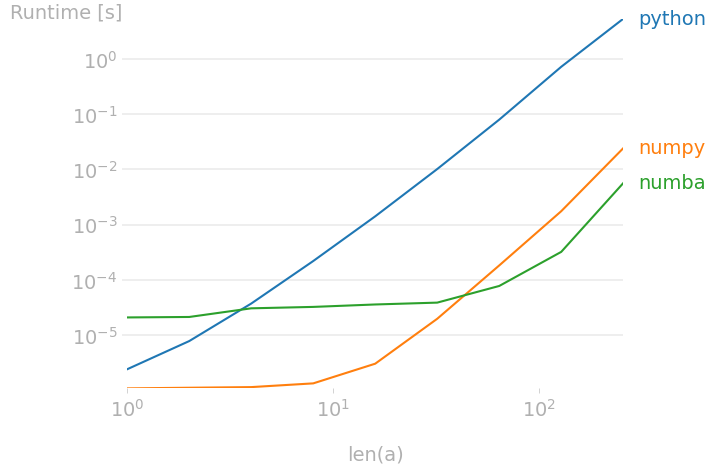

CPU times: user 1min 12s, sys: 4.85 s, total: 1min 16s
Wall time: 20.7 s


In [35]:
%%time
perfplot.show(
    setup=lambda n: np.random.randint(0, 2 ** 16, size=(n, n)),
    kernels=[
        lambda a: matmul(a, a),
        lambda a: np.matmul(a, a),
        lambda a: jmatmul(a, a),
    ],
    labels=["python", "numpy", "numba"],
    n_range=[2**k for k in range(9)],
    xlabel="len(a)",
    show_progress=True,
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
)